In [183]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import numpy as np
#matrix operations- matlab is better for matrix, but this helps python
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
#contains some operations done in matlab
from sklearn.preprocessing import normalize
#huge library for ML- use normalize- convert vector to unit vector

%matplotlib inline

In [184]:
filePathToClear = 'Output/'
if os.path.exists(filePathToClear):
    for celebDir in os.listdir(filePathToClear):
        try:
            for imagePath in os.listdir('Output/' + celebDir):
                os.remove('Output/' + celebDir + '/' + imagePath)
            os.rmdir('Output/' + celebDir)
        except:
            emptyDir = 0
else:
    os.mkdir(filePathToClear)
    

In [186]:
#This code will clear what ever is in outputMeanFaces
filePathToClear = 'OutputMeanFace/'
if os.path.exists(filePathToClear):
    for photo in os.listdir(filePathToClear):
        try:
            os.remove(filePathToClear + photo)
        except: 
            fileNotFound = 0

In [187]:
#this is from Cogs 118B HW 4

def eigsort(V, eigvals):
# Sort the eigenvalues from largest to smallest. Store the sorted # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted

    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd) 
    Vsort = np.zeros((M, M)) 
    for i in range(M):
        Vsort[:,i] = V[:,index[i]] 
    return Vsort, Dsort

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

def viewvector(columnvector):
    #This transforms the numeric vector(62500,0) of the image back into a 250 by 250 image
    
    plt.imshow(columnvector.reshape([250, 250], order='C'), cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [188]:
def meanface(celebImagePaths):
    #we want to iterate through all the photos
    faces = []
    #as we iterate, we will want to append the outcomes
    
    for imagePath in celebImagePaths:
        photo = cv2.imread(imagePath, 0)
        photo = np.array(photo)
        photo = photo.reshape([62500, ])
    
        faces.append(photo)
    
    #turn the faces list into an array
    #transpose the array
    faces = np.array(faces)
    faces = faces.T
    
    meanface = np.mean(faces, axis = 1)
    #sum along column direction, so axis = 1 (this is because each column is a unique image)
    #this is the same as (sum(faces, axis = 1)/ 48)
    meanface = meanface[:, np.newaxis].astype(int) #convert back to int value
    return meanface

In [189]:
def PCA(newDir):
    
    photosDirectory_1 = np.array(newDir)
    
    number_of_photos = len(newDir) - 1 #length will give an out of bounds index
    #we want to iterate through all the photos
    faces = []
    #as we iterate, we will want to append the outcomes
    
    for i in range(number_of_photos):
    
        #for photo in photo directory
        #get the numeric interpretation
        #turn that into an array
        #Reshape the 250 pixels by 250 pixels into a vector
        #append the vector to the faces list
        
        photo_numbers = cv2.imread(photosDirectory_1[i], 0)
        photo_array = np.array(photo_numbers)
        photo_array_reshaped = photo_array.reshape([62500, ])
    
        faces.append(photo_array_reshaped)
    
    #turn the faces list into an array
    #transpose the array
    faces = np.array(faces)
    faces = faces.T
    
    meanface = np.mean(faces, axis = 1)
    #sum along column direction, so axis = 1 (this is because each column is a unique image)
    #this is the same as (sum(faces, axis = 1)/ 48)
    meanface = meanface[:, np.newaxis]
    
    A = faces - np.matlib.repmat(meanface, 1, number_of_photos)
    
    eigvals, Vold = np.linalg.eig(A.T.dot(A))
    V, D = eigsort(Vold, eigvals)
    
    U = A.dot(V)
    U = normc(U)
    c = U.T.dot(A)
    
    return c
    

Creating list of filepaths in output directory

In [190]:
from PIL import Image

#First we load all of our files. 
def readAllFiles(datasetDir):
    photosDirectory = []
    celebList = []
    for celebName in os.listdir(datasetDir):
        path = datasetDir + celebName 
        celebList.append(path)
        pathForTemp = "Output/" + celebName
        if not os.path.exists(pathForTemp):
            os.mkdir(pathForTemp)
            #This is just to skip the file already exists error
        for photoFileName in os.listdir(path):
            photoFullPath = path + "/" + photoFileName
            photosDirectory.append(photoFullPath)
            #Dont run this code it opens every single image. (Good to see what images are being used)
            #image = Image.open(pathForPhoto) 
            #image.show()
    return photosDirectory, celebList
#photosDirectory stores the file path for each image we are gonna use
#photosDirectory



In [191]:
path = 'DatasetsToTest/TheOfficeDataset/Characters/'
photosDirectory, celebList = readAllFiles(path)

In [192]:
#Now we make a function that finds the faces of each picture
faceData = cv2.CascadeClassifier("TrainingData/haarcascade_frontalface_default.xml")
eyeData = cv2.CascadeClassifier("TrainingData/haarcascade_eye.xml")
def faceDetect(path, newDir):
    
    Photo = cv2.imread(path)
    #Blur to remove extra noise
    Photo2 = cv2.medianBlur(Photo, 3) 
    grysc = cv2.cvtColor(Photo2, cv2.COLOR_BGR2GRAY)
    faceDetected = faceData.detectMultiScale(grysc, 1.1, 4)
    eyeDetected = eyeData.detectMultiScale(grysc, 1.3, 4)
    #This area ensures only one face is found per image
    facialPadding = 15
    #The way the algorithm works is it puts faces its less confident in first and most confident last so if multiple pictures are found we just pick the last one.
    #Should work most of the time
    faceFound = False
    if(len(faceDetected) != 1):
        
        #Gets eye coordinate
        count = 0
        eye1xCoord = 0
        eye1yCoord = 0
        eye2xCoord = 0
        eye2yCoord = 0
        for(ex, ey, ew, eh) in eyeDetected:
            #Ensures only two eyes are added to the image
            if(count < 2):
                #cv2.rectangle(Photo, ((ex), (ey)),((ex+ew), (ey+eh)), (0, 0, 255), 2)
                cv2.imwrite(newDir, Photo, [cv2.IMWRITE_JPEG_QUALITY, 100])
                if(count == 0):
                    eye1xCoord = ex
                    eye1yCoord = ey
                if(count == 1):
                    eye2xCoord = ex
                    eye2yCoord = ey
                count = count + 1
        
        numFaces = len(faceDetected)
        
        for i in range(numFaces):
            x1, y1, w1, h1 = faceDetected[i]
            xrang = x1 + w1
            yrang = y1 + h1
            if(eye1xCoord, eye2yCoord != 0):
                eye1Exist = True
            if(eye2xCoord, eye2yCoord != 0):
                eye2Exist = True
            #if eyes arent found then we shouldn't put the face because it could lead to errors in our mean faces.
            if(eye1Exist, eye2Exist == True):
                if(faceFound == False):
                    if(eye1xCoord > x1):
                        if(eye1xCoord < xrang):  
                            if(eye1yCoord > y1):
                                if(eye1yCoord < yrang):
                                    faceFound = True
                                    #For our paper we can use these rectangles to visualize what we are doing
                                    #cv2.rectangle(Photo, ((x1 - facialPadding), (y1 - facialPadding)),((x1+w1+facialPadding), (y1+h1+facialPadding)), (134, 255, 20), 2)
                                    faceModified = Photo[y1-facialPadding:y1 +facialPadding+h1, x1-facialPadding:x1+facialPadding+w1]
                                    photo = cv2.resize(faceModified, (250, 250))
                                    cv2.imwrite(newDir, photo, [cv2.IMWRITE_JPEG_QUALITY, 100])

    else:
        (x, y, w, h) = faceDetected[0]
        faceFound = True
        faceModified = Photo[y-facialPadding:y+facialPadding+h,x-facialPadding:x+facialPadding+w]
        photo1 = cv2.resize(faceModified, (250, 250))
        cv2.imwrite(newDir, photo1, [cv2.IMWRITE_JPEG_QUALITY, 100])
        
    if(faceFound == False):
        #Delete faces that couldn't be centered
        print('No face found: ' + newDir)
        try:
            os.remove(newDir)
        except:
            alreadyRemoved = 0


In [193]:
allOutputPaths = []

#Detecting faces from source directory (path) and outputting resized images to Output/
for photoPath in photosDirectory:
    outputPath = photoPath.replace(path, "Output/") #Creating output filepath
    faceDetect(photoPath, outputPath) #Writing images to outputPaths
    allOutputPaths.append(outputPath) #Saving filepath of output image

No face found: Output/Angela Martin/AngelaMartin_1.jpg
No face found: Output/Angela Martin/AngelaMartin_8.jpg
No face found: Output/Darryl Philbin/DarrylPhilbin_3.jpg
No face found: Output/Dwight Schrute/DwightSchrute_7.jpg
No face found: Output/Erin Hannon/ErinHannon_5.jpg
No face found: Output/Erin Hannon/ErinHannon_8.jpg
No face found: Output/Kelly Kapoor/KellyKapoor_6.jpg
No face found: Output/Michael Scott/MichaelScott_4.jpg
No face found: Output/Pam Beesly/PamBeesly_7.jpg


In [194]:
#remove empty files
for file in allOutputPaths:
    if not os.path.exists(file):
        allOutputPaths.remove(file)

In [195]:
import math

def faceAlignRotate(imagePath):
    #Now we have to allign each face based on the angle of their eyes
    #for PhotoDirectory in Dir:
    try:
        eyeData = cv2.CascadeClassifier("TrainingData/haarcascade_eye.xml")
        photo = cv2.imread(imagePath)
        photo = cv2.medianBlur(photo, 5)  
        grayPhoto = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
        eyesLoc = eyeData.detectMultiScale(grayPhoto, 1.4, 4)
        loc = 0
        for(eyeXcoord, eyeYcoord, eyeWcoord, eyeHcoord) in eyesLoc:
            if(loc == 0):
                eye1 = (eyeXcoord, eyeYcoord, eyeWcoord, eyeHcoord)
            else:
                eye2 = (eyeXcoord, eyeYcoord, eyeWcoord, eyeHcoord)
            cv2.rectangle(photo, (eyeXcoord, eyeYcoord), (eyeXcoord+eyeWcoord, eyeYcoord+eyeHcoord),(0, 0, 255), 2)
            loc = loc + 1
    
        #Now we determine which eye corresponds with which side of the face
        if eye1[0] < eye2[0]:
            leftEye = eye1
            rightEye = eye2
        else:
            leftEye = eye2
            rightEye = eye1
        #Now we calculate the coordiantes of the eye
        leftEyeIris = (int(leftEye[0] + (leftEye[2]/2)), int(leftEye[1] + (leftEye[3]/2)))
        leftEyeXcoord = leftEyeIris[0]
        leftEyeYcoord = leftEyeIris[1]
        
        rightEyeIris = (int(rightEye[0] + (rightEye[2]/2)),int(rightEye[1] + (rightEye[3]/2)))
        rightEyeXcoord = rightEyeIris[0]
        rightEyeYcoord = rightEyeIris[1]
        cv2.circle(photo, leftEyeIris, 2, (0, 255, 0), 2)
        cv2.circle(photo, rightEyeIris, 2, (0, 255, 0), 2)
        cv2.line(photo, rightEyeIris, leftEyeIris, (255, 0, 0), 2)
        
        if leftEyeIris < rightEyeIris:
            point = (rightEyeXcoord, leftEyeYcoord)
            direction = -1
        else:
            point = (leftEyeXcoord, rightEyeYcoord)
            direction = 1
        cv2.circle(photo, point, 2, (255, 0, 0), 2)
        cv2.line(photo, rightEyeIris, leftEyeIris, (67, 67, 67), 2)
        cv2.line(photo, leftEyeIris, point, (67, 67, 67), 2)
        cv2.line(photo, rightEyeIris, point, (67, 67, 67), 2)

        firstCoord = np.linalg.norm(np.array(leftEyeIris)-np.array(point))
        secondCoord = np.linalg.norm(np.array(rightEyeIris)-np.array(leftEyeIris))
        thirdCoord = np.linalg.norm(np.array(rightEyeIris)-np.array(point))
    
        cos = (secondCoord**2 + thirdCoord**2 - firstCoord**2) / (2*secondCoord*thirdCoord)
        #cos = cos
        
        angle = np.arccos(cos)
        angle = (angle * 180) / math.pi #converting to degrees
        
        if(direction == -1):
            angle = 90-angle
        #Now we generate the new image based on the angle

        imageToRotate = Image.open(imagePath)
        rotation = angle*direction
        #Prevents rotations that are too extreme
        if(rotation < 20):
            if(rotation > -20):
                rotated = imageToRotate.rotate(rotation)
                rotated.save(imagePath)
    except:
        donothing = 0

In [196]:
for path in allOutputPaths:
    faceAlignRotate(path)

C:\Users\j9garcia\AppData\Local\Temp/ipykernel_37556/1599600266.py:55: RuntimeWarning: invalid value encountered in double_scalars
  cos = (secondCoord**2 + thirdCoord**2 - firstCoord**2) / (2*secondCoord*thirdCoord)


In [197]:
#this will get all of the pictures for each person
def getCelebImagePaths(celebDir):    
    pathList = []
    for imagePath in os.listdir('Output/' + celebDir + '/'):
        fullPath = 'Output/' + celebDir + '/' + imagePath
        pathList.append(fullPath)
    return pathList

In [198]:
meanfaces = []
celebList = []
for celeb in os.listdir('Output/'):
    celebList.append(celeb)
    meanfaces.append(meanface(getCelebImagePaths(celeb)))

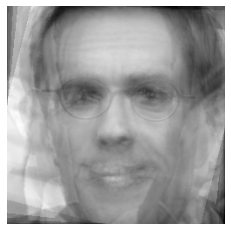

In [199]:
viewvector(meanfaces[0])

In [200]:
meanFolderPath = "OutputMeanface"

if not os.path.exists(meanFolderPath):
    os.mkdir(meanFolderPath)

for i in range(len(meanfaces)):
    cv2.imwrite(meanFolderPath + '/' + celebList[i] + "_meanface.jpeg", meanfaces[i].reshape([250, 250], order='C'))

In [201]:
def guessPerson(imagePathToCheck): #use full path
    if not os.path.exists('temp'):
        os.mkdir('temp')
    outputPath = 'temp/' + imagePathToCheck.split('/')[-1]
    faceDetect(imagePathToCheck, outputPath) #Writing image to outputPath
    faceAlignRotate(outputPath)
    testPhoto = cv2.imread(outputPath, 0).astype(int)
    
    lowestErr = -1
    closestPerson = ''
    for currPath in os.listdir(meanFolderPath):
        currMeanPhoto = cv2.imread(meanFolderPath+'/'+currPath, 0).astype(int)
        currErr = np.linalg.norm(testPhoto - currMeanPhoto)
        if (lowestErr == -1) or (currErr < lowestErr):
            lowestErr = currErr
            closestPerson = currPath
    # folder to save to -> print(closestPerson[:-len('_meanface.jpeg')])
    filePAth = (closestPerson[:-len('_meanface.jpeg')])
    photo = cv2.imread(outputPath, 0)
    cv2.imwrite(os.path.join('Output/' + filePAth + '/' + imagePathToCheck.split('/')[-1]), photo)
    
    os.remove(outputPath)
    os.rmdir('temp')
    return closestPerson[:-len('_meanface.jpeg')]
        
        


In [202]:
def updateMeans():
    meanfaces = []
    celebList = []
    for celeb in os.listdir('Output/'):
        celebList.append(celeb)
        meanfaces.append(meanface(getCelebImagePaths(celeb)))
    for i in range(len(meanfaces)):
        cv2.imwrite(meanFolderPath + '/' +
                    celebList[i] + "_meanface.jpeg", meanfaces[i].reshape([250, 250], order='C'))


In [203]:
#PATH TO TESTFILES HERE
pathToTest = 'DatasetsToTest/TheOfficeDataset/TestFiles/'
#SaveToTempTest = 'TempTest/'
#faceDetect(pathToTest, newDir):
#To test all faces in the directory try
directorys = os.listdir(pathToTest)
for celebsToTest in directorys:
    guess = guessPerson('DatasetsToTest/TheOfficeDataset/TestFiles/' + celebsToTest)
    updateMeans()
    print(guess)



Dwight Schrute
Pam Beesly
Angela Martin
Angela Martin
Creed Bratton
Creed Bratton
Kelly Kapoor
Darryl Philbin
Michael Scott
Pam Beesly


C:\Users\j9garcia\AppData\Local\Temp/ipykernel_37556/1599600266.py:55: RuntimeWarning: invalid value encountered in double_scalars
  cos = (secondCoord**2 + thirdCoord**2 - firstCoord**2) / (2*secondCoord*thirdCoord)


Jim Halpert
Erin Hannon
Darryl Philbin
Andy Bernard
Jim Halpert
Kelly Kapoor
Michael Scott
Pam Beesly
Kelly Kapoor
Pam Beesly


FOR AUDRY: 
all data inputs will have to be faceDetected and faceAlignRotated. Can follow example in guessPerson() function.
instead of saving to temp/, they will be saved to Output/, as shown in an earlier code block

Iterate through each TestInput filepath with guessPerson() and it will return who it thinks the picture is.